In [4]:
import numpy as np
from scipy.sparse import load_npz
import os

In [7]:
X_train = load_npz('../vectors/tfidf_lemma/X_train_tfidf.npz')
y_train = np.load('../vectors/tfidf_lemma/y_train.npy')

In [8]:
from sklearn.model_selection import cross_val_score

In [43]:
class_weights = dict(zip(range(len(np.unique(y_train))), 1 / np.bincount(y_train)))

In [9]:
from sklearn import naive_bayes

NB = naive_bayes.MultinomialNB()

scores = cross_val_score(NB, X_train, y_train, cv=10)

print(scores)
scores.mean()

[0.44359756 0.47256098 0.4222561  0.44207317 0.44359756 0.43597561
 0.42835366 0.44817073 0.4527439  0.46189024]


0.4451219512195122

In [10]:
from sklearn.svm import SVC

SVM = SVC()

scores = cross_val_score(SVM, X_train, y_train, cv=10)

print(scores)
scores.mean()

[0.51981707 0.51676829 0.48932927 0.49847561 0.50304878 0.50304878
 0.49390244 0.51829268 0.52896341 0.49695122]


0.5068597560975611

In [11]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()

RF_scores = cross_val_score(RF, X_train, y_train, cv=10)

print(RF_scores)
RF_scores.mean()

[0.50914634 0.5320122  0.51067073 0.5        0.50914634 0.5320122
 0.51219512 0.50304878 0.49085366 0.51219512]


0.5111280487804878

## Encontrando melhores hiperparametros para o RFC

In [12]:
import optuna
from sklearn.ensemble import RandomForestClassifier

c:\Users\felma\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 50, 200),
    }

    model = RandomForestClassifier(**params)

    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return score

In [ ]:
study = optuna.create_study(direction='maximize')  # Estamos maximizando a acurácia
study.optimize(objective, n_trials=50)

In [ ]:
print("Melhores Hiperparâmetros:", study.best_params)
print("Melhor Acurácia Encontrada:", study.best_value)

Melhores Hiperparâmetros: {'n_estimators': 171, 'max_depth': 118}
Melhor Acurácia Encontrada: 0.5153963414634146


In [44]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=118, max_depth=143, class_weight=class_weights)

RF_scores = cross_val_score(RF, X_train, y_train, cv=10)

print(RF_scores)
RF_scores.mean()

[0.51067073 0.51371951 0.51676829 0.50609756 0.51219512 0.53658537
 0.52286585 0.5304878  0.51219512 0.51676829]


0.5178353658536585

In [45]:
from sklearn.metrics import accuracy_score

X_test = load_npz('../vectors/tfidf_lemma/X_test_tfidf.npz')
y_test = np.load('../vectors/tfidf_lemma/y_test.npy')

RF.fit(X_train, y_train)

RF_y_pred = RF.predict(X_test)

accuracy_score(y_test, RF_y_pred)

0.5128048780487805

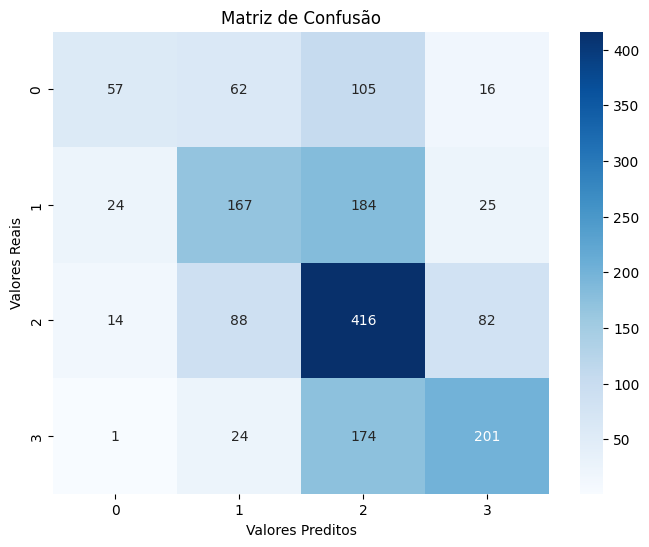

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['0','1','2','3']

cm1 = confusion_matrix(y_test, RF_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

## Encontrando melhores hiperparametros para o SVC

In [26]:
from sklearn.svm import SVC

def objective(trial):
    params = {
        'C': trial.suggest_int('C', 1e-3, 1e3),
    }

    model = SVC(**params)

    score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5).mean()

    return score

In [ ]:
study = optuna.create_study(direction='maximize')  # Estamos maximizando a acurácia
study.optimize(objective, n_trials=50)

In [ ]:
print("Melhores Hiperparâmetros:", study.best_params)
print("Melhor Acurácia Encontrada:", study.best_value)

In [54]:
SVM = SVC(class_weight='balanced')

SVM.fit(X_train, y_train)

SVM_y_pred = SVM.predict(X_test)

accuracy_score(y_test, SVM_y_pred)

0.5042682926829268

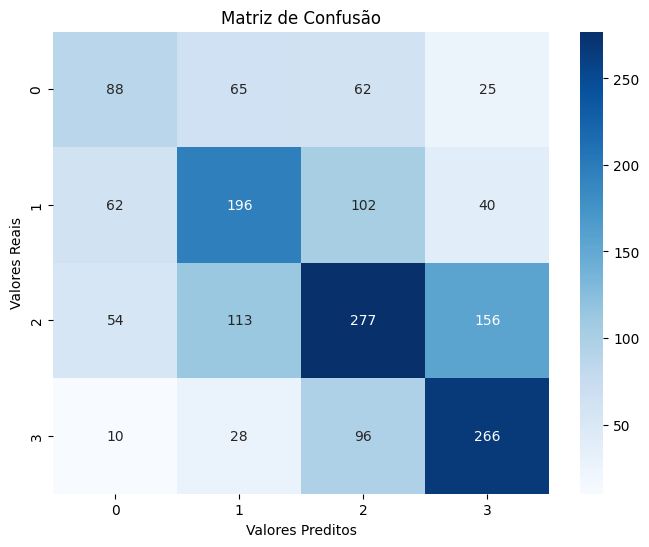

In [55]:
cm2 = confusion_matrix(y_test, SVM_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

In [50]:
NB = naive_bayes.MultinomialNB()

NB.fit(X_train, y_train)

NB_y_pred = NB.predict(X_test)

accuracy_score(y_test, SVM_y_pred)

0.36585365853658536

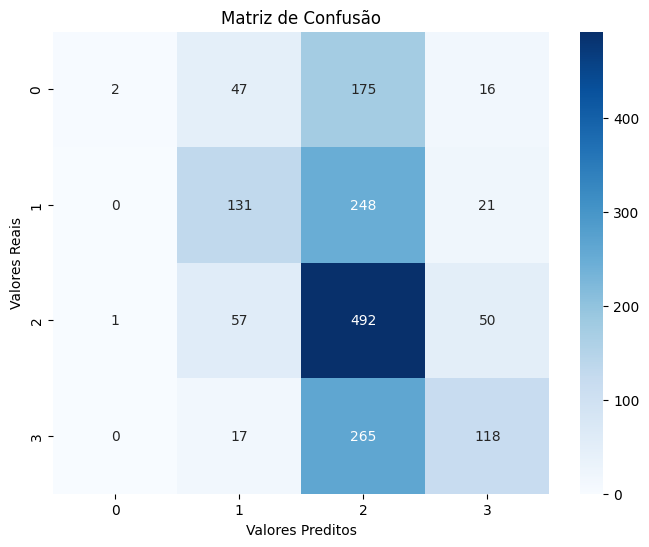

In [51]:
cm3 = confusion_matrix(y_test, NB_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

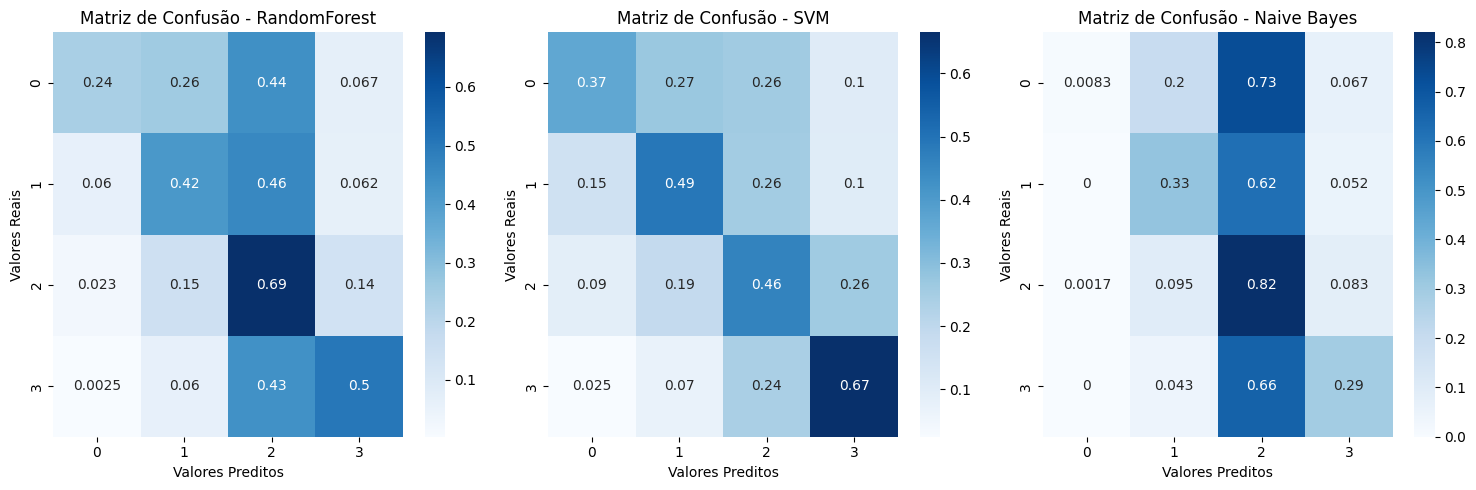

In [56]:
# Configurar subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

# Plotar cada matriz de confusão em um subplot
for i, (cm, model_name) in enumerate(zip([cm1, cm2, cm3], ['RandomForest', 'SVM', 'Naive Bayes'])):
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_title(f'Matriz de Confusão - {model_name}')
    axes[i].set_xlabel('Valores Preditos')
    axes[i].set_ylabel('Valores Reais')

plt.tight_layout()
plt.show()

In [53]:
import pandas as pd

df = pd.read_csv('../data/enc_tok_nopunct_lemm.csv')
df['age_encoded'].value_counts()


age_encoded
2    3000
1    2000
3    2000
0    1200
Name: count, dtype: int64